In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, roc_curve, roc_auc_score, f1_score
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import math
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub

In [34]:
def evaluation_matrix(y_true,y_pred):
    '''
    eval_dictionary=evaluation_matrix(y_true,y_pred)
    '''
    f1score=f1_score(y_true,y_pred)
    accuracy=sum(y_true==y_pred)/len(y_true)
    tn, fp, fn, tp =confusion_matrix(y_true,y_pred).ravel()
    pre_score=precision_score(y_true,y_pred)
    res={'f1_score':f1score,
        'accuracy':accuracy,
        'False Positive':fp,
        'False Negative':fn,
        'precision_score':pre_score}
    return res

def split_data(train_path,split_ratio,seed):
    '''
    X_train, X_val, y_train, y_val=split_data(train_path,split_ratio,seed)
    '''
    train_df=pd.read_csv(train_path)
    # randomize the data
    train_shuffle_df=train_df[['text','target']].sample(frac=1,random_state=seed)
    X=train_shuffle_df['text'].to_numpy()
    y=train_shuffle_df['target'].to_numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_ratio, random_state=seed)
    return X_train, X_val, y_train, y_val

# you can choose TfidfVectorizer(), or CountVectorizer for the vectorization part
# you can choose SVC, XGBClassifier, MultinomialNB or KNeighborsClassifier
def sklearn_model(vec_name,vec_module,clasi_name,clasi_module,X_train,y_train):
    model=Pipeline([(vec_name,vec_module),(clasi_name,clasi_module)])
    model.fit(X_train,y_train)
    return model

def vectorizer_embed_layer_generator(X_train,output_dim):
    '''
    
    text_vectorizer,embed_layer=vectorizer_embed_layer_generator(X_train,output_dim)
    
    '''
    avg_len=np.average([len(sentence.split()) for sentence in X_train])
    max_len=int(np.ceil(avg_len))
    word_pool=set()
    # calculate total number of unique word
    for sentence in X_train:
        for ele in sentence.split():
            if ele.strip() not in word_pool:
                word_pool.add(ele.strip())
    max_tokens=len(word_pool)
    del word_pool
    
    text_vectorizer=TextVectorization(max_tokens=max_tokens, output_mode='int',output_sequence_length=max_len)
    text_vectorizer.adapt(X_train)
    
    embed_layer=tf.keras.layers.Embedding(input_dim=max_tokens,output_dim=output_dim,input_length=max_len)
    
    return text_vectorizer, embed_layer


#### Model combination
model_0: MultinomialNB with tfidf Vectorizer

model_1: MultinomialNB with CountVectorizer 

model_2: SVM with TfidfVectorizer 

model_3: SVM with CountVectorizer

model_4: XGBClassifier with TfidfVectorizer

model_5: XGBClassifier with CountVectorizer

model_6: KNN Classifier with TfidfVectorizer

model_7: NN model (tensorflow)

model_8: change flatten() to globalmaxpool1D

model_9: LSTM

model_10: GRU

model_11: Bidirectional LSTM

model_12: transfer learning: feature extraction


In [35]:
model_matrix={}
eval_matrix={}
X_train, X_val, y_train, y_val=split_data('train.csv',split_ratio=0.2,seed=101)

In [36]:
# you can choose TfidfVectorizer(), or CountVectorizer for the vectorization part
# you can choose SVC, XGBClassifier, MultinomialNB or KNeighborsClassifier

In [37]:
model_matrix[0]=sklearn_model('tfidf',TfidfVectorizer(),'MultinomialNB',MultinomialNB(),X_train,y_train)
model_matrix[1]=sklearn_model('count Vector', CountVectorizer(),'MultinomialNB',MultinomialNB(),X_train,y_train)
model_matrix[2]=sklearn_model('tfidf',TfidfVectorizer(),'SVC',SVC(),X_train,y_train)
model_matrix[3]=sklearn_model('count Vector', CountVectorizer(),'SVC',SVC(),X_train,y_train)
model_matrix[4]=sklearn_model('tfidf',TfidfVectorizer(),'XGBClassifier',XGBClassifier(),X_train,y_train)
model_matrix[5]=sklearn_model('count Vector', CountVectorizer(),'XGBClassifier',XGBClassifier(),X_train,y_train)
model_matrix[6]=sklearn_model('tfidf',TfidfVectorizer(),'KNN',KNeighborsClassifier(),X_train,y_train)

In [38]:
for i in range(7):
    y_pred=model_matrix[i].predict(X_val)
    eval_matrix[i]=evaluation_matrix(y_val,y_pred)

In [39]:
## For tensorflow
text_vectorizer,embed_layer=vectorizer_embed_layer_generator(X_train,output_dim=512)

In [40]:
inputs = tf.keras.Input(shape=(X_train.ndim,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed_layer(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model_matrix[7]=tf.keras.Model(inputs=inputs,outputs=outputs)
model_matrix[7].compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model_matrix[7].fit(x=X_train,y=y_train,steps_per_epoch=0.1*len(X_train), validation_data=(X_val,y_val),validation_steps=0.1*len(X_val),epochs=5, callbacks=[callback])

Epoch 1/5
609/609 [==============================] - 7s 10ms/step - loss: 0.5219 - accuracy: 0.7427 - val_loss: 0.4965 - val_accuracy: 0.7715
Epoch 2/5
609/609 [==============================] - 6s 10ms/step - loss: 0.1466 - accuracy: 0.9488 - val_loss: 0.6768 - val_accuracy: 0.7439
Epoch 3/5
609/609 [==============================] - 6s 10ms/step - loss: 0.0400 - accuracy: 0.9837 - val_loss: 0.7815 - val_accuracy: 0.7571


In [41]:
y_pred=np.round(np.squeeze(model_matrix[7].predict(X_val)))

In [42]:
model_matrix[7]=evaluation_matrix(y_val,y_pred)

In [43]:
# model_8: change flatten() to globalmaxpool1D
inputs = tf.keras.Input(shape=(X_train.ndim,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed_layer(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model_matrix[8]=tf.keras.Model(inputs=inputs,outputs=outputs)
model_matrix[8].compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model_matrix[8].fit(x=X_train,y=y_train,steps_per_epoch=0.1*len(X_train), validation_data=(X_val,y_val),validation_steps=0.1*len(X_val),epochs=5, callbacks=[callback])
y_pred=np.round(np.squeeze(model_matrix[8].predict(X_val)))
eval_matrix[8]=evaluation_matrix(y_val,y_pred)

Epoch 1/5
609/609 [==============================] - 7s 10ms/step - loss: 0.3201 - accuracy: 0.8703 - val_loss: 0.5902 - val_accuracy: 0.7689
Epoch 2/5
609/609 [==============================] - 6s 10ms/step - loss: 0.1023 - accuracy: 0.9627 - val_loss: 0.7434 - val_accuracy: 0.7610
Epoch 3/5
609/609 [==============================] - 6s 10ms/step - loss: 0.0400 - accuracy: 0.9893 - val_loss: 0.8934 - val_accuracy: 0.7590


In [44]:
# model_9:  LSTM
inputs=tf.keras.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed_layer(x)
x=tf.keras.layers.LSTM(units=64,return_sequences=False)(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model_matrix[9]=tf.keras.Model(inputs=inputs,outputs=outputs)
model_matrix[9].compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model_matrix[9].fit(x=X_train,y=y_train,steps_per_epoch=0.1*len(X_train), validation_data=(X_val,y_val),validation_steps=0.1*len(X_val),epochs=5, callbacks=[callback])
y_pred=np.round(np.squeeze(model_matrix[9].predict(X_val)))
eval_matrix[9]=evaluation_matrix(y_val,y_pred)

Epoch 1/5
609/609 [==============================] - 8s 12ms/step - loss: 0.2003 - accuracy: 0.9284 - val_loss: 0.6252 - val_accuracy: 0.7479
Epoch 2/5
609/609 [==============================] - 7s 12ms/step - loss: 0.0573 - accuracy: 0.9791 - val_loss: 0.9171 - val_accuracy: 0.7124
Epoch 3/5
609/609 [==============================] - 7s 11ms/step - loss: 0.0299 - accuracy: 0.9905 - val_loss: 1.0019 - val_accuracy: 0.7564


In [45]:
# model_10: GRU
inputs=tf.keras.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(inputs)
x=embed_layer(x)
x=tf.keras.layers.GRU(64)(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model_matrix[10]=tf.keras.Model(inputs=inputs,outputs=outputs)
model_matrix[10].compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model_matrix[10].fit(x=X_train,y=y_train,steps_per_epoch=0.1*len(X_train), validation_data=(X_val,y_val),validation_steps=0.1*len(X_val),epochs=5, callbacks=[callback])
y_pred=np.round(np.squeeze(model_matrix[10].predict(X_val)))
eval_matrix[10]=evaluation_matrix(y_val,y_pred)

Epoch 1/5
609/609 [==============================] - 9s 12ms/step - loss: 0.0912 - accuracy: 0.9673 - val_loss: 0.9592 - val_accuracy: 0.7433
Epoch 2/5
609/609 [==============================] - 7s 12ms/step - loss: 0.0208 - accuracy: 0.9926 - val_loss: 1.4117 - val_accuracy: 0.7485
Epoch 3/5
609/609 [==============================] - 7s 12ms/step - loss: 0.0152 - accuracy: 0.9938 - val_loss: 1.3548 - val_accuracy: 0.7498


In [46]:
# model_11: Bidirectional LSTM
input=tf.keras.Input(shape=(1,),dtype=tf.string)
x=text_vectorizer(input)
x=embed_layer(x)
x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
output=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model_matrix[11]=tf.keras.Model(inputs=input,outputs=output)
model_matrix[11].compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model_matrix[11].fit(x=X_train,y=y_train,steps_per_epoch=0.1*len(X_train), validation_data=(X_val,y_val),validation_steps=0.1*len(X_val),epochs=5, callbacks=[callback])
y_pred=np.round(np.squeeze(model_matrix[11].predict(X_val)))
eval_matrix[11]=evaluation_matrix(y_val,y_pred)

Epoch 1/5
609/609 [==============================] - 11s 15ms/step - loss: 0.0489 - accuracy: 0.9841 - val_loss: 1.2778 - val_accuracy: 0.7387
Epoch 2/5
609/609 [==============================] - 9s 14ms/step - loss: 0.0137 - accuracy: 0.9936 - val_loss: 1.3576 - val_accuracy: 0.7374
Epoch 3/5
609/609 [==============================] - 9s 14ms/step - loss: 0.0113 - accuracy: 0.9943 - val_loss: 1.8740 - val_accuracy: 0.7137


In [47]:
# model_12: transfer learning: feature extraction

embed_layer=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False,dtype=tf.string)
inputs=tf.keras.Input(shape=(),dtype=tf.string)
x=embed_layer(inputs)
x=tf.keras.layers.Dense(32,activation='relu')(x)
x=tf.keras.layers.Dense(16,activation='relu')(x)
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(x)
model_matrix[12]=tf.keras.Model(inputs=inputs,outputs=outputs)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model_matrix[12].compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_matrix[12].fit(x=X_train,y=y_train,steps_per_epoch=0.1*len(X_train), validation_data=(X_val,y_val),validation_steps=0.1*len(X_val),epochs=5, callbacks=[callback])
y_pred=np.round(np.squeeze(model_matrix[12].predict(X_val)))
eval_matrix[12]=evaluation_matrix(y_val,y_pred)

Epoch 1/5
609/609 [==============================] - 9s 11ms/step - loss: 0.4803 - accuracy: 0.7829 - val_loss: 0.4621 - val_accuracy: 0.7958
Epoch 2/5
609/609 [==============================] - 7s 11ms/step - loss: 0.4008 - accuracy: 0.8268 - val_loss: 0.4545 - val_accuracy: 0.8056
Epoch 3/5
609/609 [==============================] - 6s 10ms/step - loss: 0.3823 - accuracy: 0.8322 - val_loss: 0.4454 - val_accuracy: 0.8083
Epoch 4/5
609/609 [==============================] - 7s 11ms/step - loss: 0.3652 - accuracy: 0.8432 - val_loss: 0.4536 - val_accuracy: 0.8070
Epoch 5/5
609/609 [==============================] - 7s 11ms/step - loss: 0.3475 - accuracy: 0.8516 - val_loss: 0.4573 - val_accuracy: 0.8070


In [58]:
model_matrix[12].summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None,)]                 0         
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_36 (Dense)             (None, 32)                16416     
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 256,814,785
Trainable params: 16,961
Non-trainable params: 256,797,824
_________________________________________________________________


In [56]:
result=pd.DataFrame(eval_matrix.values())

In [62]:
result['model_no']=[f'model_{i}'for i in result.index]

In [63]:
result

,f1_score,accuracy,False Positive,False Negative,precision_score,model_no
0,0.718039,0.788575,71,251,0.852391,model_0
1,0.740081,0.789232,117,204,0.796167,model_1
2,0.760634,0.811556,82,205,0.847584,model_2
3,0.725862,0.791202,78,240,0.843687,model_3
4,0.703259,0.772817,95,251,0.811881,model_4
5,0.729412,0.788575,95,227,0.820416,model_5
6,0.715824,0.774787,114,229,0.791209,model_6
7,0.714397,0.759028,165,202,0.735577,model_7
8,0.702486,0.756402,148,223,0.747440,model_8
9,0.686935,0.749836,138,243,0.751799,model_9


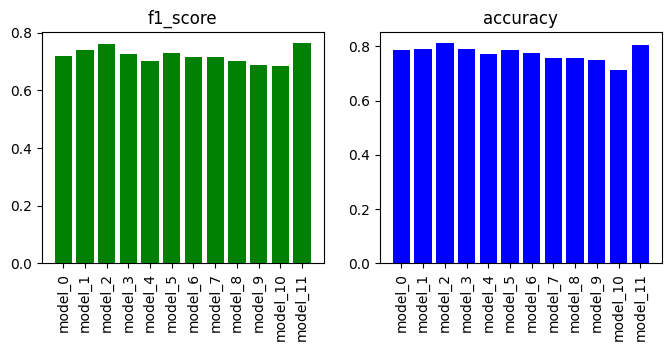

In [72]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.bar('model_no','f1_score',data=result,color='green')
plt.title('f1_score')
plt.xticks(rotation=90)
plt.subplot(1,2,2)
plt.bar('model_no','accuracy',data=result,color='blue')
plt.title('accuracy')
plt.xticks(rotation=90)
plt.show()


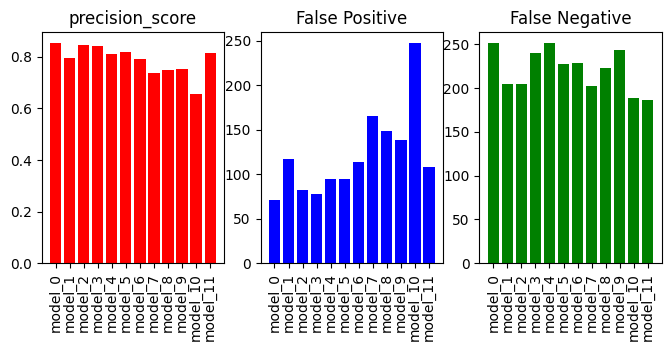

In [75]:
plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
plt.bar('model_no','precision_score',data=result,color='red')
plt.title('precision_score')
plt.xticks(rotation=90)
plt.subplot(1,3,2)
plt.bar('model_no','False Positive',data=result,color='blue')
plt.title('False Positive')
plt.xticks(rotation=90)
plt.subplot(1,3,3)
plt.bar('model_no','False Negative',data=result,color='green')
plt.title('False Negative')
plt.xticks(rotation=90)
plt.show()
